IMPORTING MODULES

In [2]:
import os
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from transformers import BertTokenizer, TFBertModel

LOADING DATASET

In [3]:
df = pd.read_csv('/Users/alex/Desktop/projects/SpamDetector/dataset/spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


EXAMINING DATASET

In [4]:
df.shape

(5572, 2)

In [5]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [6]:
df.groupby(df['Category']).count()

,Message
Category,
ham,4825
spam,747


CLASS IMBALANCE PROBLEM

In [7]:
spam_df = df[df['Category']=='spam']
ham_df = df[df['Category']=='ham'].sample(spam_df.shape[0])
df2 = pd.concat([spam_df, ham_df], axis=0)

ONE-HOT ENCODING LABEL

In [8]:
dummy_label = pd.get_dummies(df2['Category'], dtype=int, drop_first=True)
df3 = pd.concat([df2, dummy_label], axis=1)
df3.drop('Category', axis=1, inplace=True)
df3

,Message,spam
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,FreeMsg Hey there darling it's been 3 week's n...,1
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1
11,"SIX chances to win CASH! From 100 to 20,000 po...",1
...,...,...
4234,My love ... I hope your not doing anything dra...,0
1709,How's my loverboy doing ? What does he do that...,0
3663,"What are you doing in langport? Sorry, but I'l...",0
4105,Do u hav any frnd by name ashwini in ur college?,0


SPLITTING THE DATA INTO TRAINING AND TESTING SET

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df3.drop('spam', axis=1), df3['spam'], test_size=0.2, random_state=42, stratify=df3['spam'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1195, 1), (299, 1), (1195,), (299,))

BERT FOR SENTENCE EMBEDDING

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoder = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
X_train_tokenized = tokenizer(list(X_train['Message']), padding=True, truncation=True, return_tensors='tf')
X_train_encoded = encoder(X_train_tokenized).pooler_output

MODEL BUILD AND TUNING

In [32]:
THRESHOLD = 0.6
METRICS = [
    tf.keras.metrics.BinaryAccuracy(threshold = THRESHOLD, name='accuracy'),
    tf.keras.metrics.Recall(thresholds = THRESHOLD, name='recall'),
    tf.keras.metrics.Precision(thresholds = THRESHOLD, name='precision'),
    tf.keras.metrics.AUC(num_thresholds=100, name='auc')
]
LEARNING_RATE = 0.003
VALIDATION_SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 32

In [48]:
def create_model(LEARNING_RATE, METRICS):
    #Model creation function
    my_model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, input_shape=(1195, 768), activation='tanh', return_sequences=True)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    
    my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = [METRICS])
    
    return my_model

my_model = create_model(LEARNING_RATE, METRICS)

MODEL TRAINING

In [49]:
def model_train(model, x, y, validation_split, epochs, batch_size):
    #Model training function
    history = model.fit(x, y, validation_split=validation_split, epochs=epochs, batch_size=batch_size)
    return history

X_train_reshaped = tf.expand_dims(X_train_encoded, axis=1)

In [50]:
history = model_train(my_model, X_train_reshaped, y_train, VALIDATION_SPLIT, EPOCHS, BATCH_SIZE)

Epoch 1/20
30/30 [==============================] - 3s 25ms/step - loss: 0.5375 - accuracy: 0.7705 - recall: 0.6699 - precision: 0.8383 - auc: 0.8667 - val_loss: 0.3427 - val_accuracy: 0.8745 - val_recall: 0.9250 - val_precision: 0.8409 - val_auc: 0.9445
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.3584 - accuracy: 0.8588 - recall: 0.8452 - precision: 0.8688 - auc: 0.9192 - val_loss: 0.2899 - val_accuracy: 0.8828 - val_recall: 0.8000 - val_precision: 0.9600 - val_auc: 0.9610
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2568 - accuracy: 0.9079 - recall: 0.8912 - precision: 0.9221 - auc: 0.9553 - val_loss: 0.2053 - val_accuracy: 0.9414 - val_recall: 0.9333 - val_precision: 0.9492 - val_auc: 0.9752
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2326 - accuracy: 0.9006 - recall: 0.8661 - precision: 0.9303 - auc: 0.9675 - val_loss: 0.1658 - val_accuracy: 0.9414 - val_recall: 0.9167 - val_precision: 0.9649 -

MODEL EVALUATION

In [16]:
X_test_tokenized = tokenizer(list(X_test['Message']), padding=True, truncation=True, return_tensors='tf')
X_test_encoded = encoder(X_test_tokenized).pooler_output

In [51]:
X_test_reshaped = tf.expand_dims(X_test_encoded, axis=1)
my_model.evaluate(x = X_test_reshaped, y = y_test, batch_size=32)

10/10 [==============================] - 0s 2ms/step - loss: 0.1217 - accuracy: 0.9666 - recall: 0.9664 - precision: 0.9664 - auc: 0.9875


[0.12167578935623169,
 0.9665551781654358,
 0.9664429426193237,
 0.9664429426193237,
 0.9875167608261108]

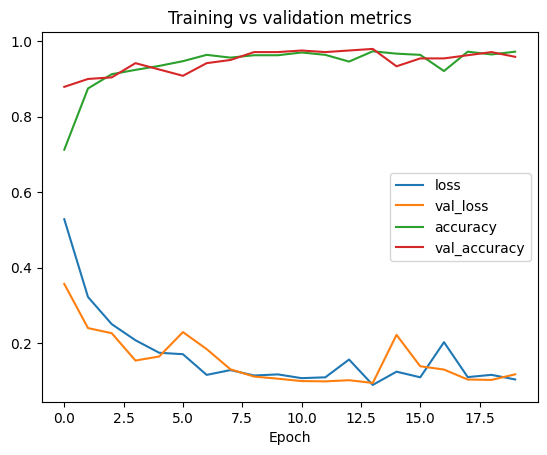

In [37]:
model_metrics = pd.DataFrame(history.history)
model_epochs = history.epoch
eval_metrics = ['loss','val_loss','accuracy','val_accuracy']

def plot_metrics(eval_metrics, model_metrics, model_epochs):
    #Ploting metrics
    for metric in eval_metrics:
        plt.plot(model_epochs, model_metrics[metric], label=metric)
    plt.legend()
    plt.xlabel('Epoch')
    plt.title('Training vs validation metrics')

plot_metrics(eval_metrics, model_metrics, model_epochs)

In [38]:
def testing_output(model, text):
    tokenized_text = tokenizer(list(text), padding=True, truncation=True, return_tensors='tf')
    encoded_text = encoder(tokenized_text).pooler_output
    reshaped_text = tf.expand_dims(encoded_text, axis=1)
    result = (model.predict(reshaped_text)>0.7).astype(int)
    return result


In [39]:
test_text_ham=["Hi, I'm Alex. can't wait to meet you soon!"]
test_text_spam = ["We've updated our login credential policy. Please confirm your account by logging into Google Docs."]

In [40]:
testing_output(my_model, test_text_ham)

1/1 [==============================] - 0s 388ms/step


array([[[0]]])

In [43]:
testing_output(my_model, test_text_spam)

1/1 [==============================] - 0s 9ms/step


array([[[1]]])

SAVING THE MODEL

In [42]:
def save_model(model, folder_path):
    def find_next_model_index(folder_path):
        model_index = 0
        while os.path.exists(os.path.join(folder_path, f'model_{model_index}.keras')):
            model_index += 1
        return model_index
    
    model_index = find_next_model_index(folder_path)
    model_filename = os.path.join(folder_path, f'model_{model_index}.keras')
    model.save(model_filename)

save_model(my_model, '../models/')